#Project: Analyzing Runkeeper Fitness Data


One day, my old running friend and I were chatting about our running styles, training habits, and achievements, when I suddenly realized that I could take an in-depth analytical look at my training. I have been using a popular GPS fitness tracker called Runkeeper for years and decided it was time to analyze my running data to see how I was doing.

Since 2012, I've been using the Runkeeper app, and it's great. One key feature: its excellent data export. Anyone who has a smartphone can download the app and analyze their data like we will in this notebook.

After logging your run, the first step is to export the data from Runkeeper (which I've done already). Then import the data and start exploring to find potential problems. After that, create data cleaning strategies to fix the issues. Finally, analyze and visualize the clean time-series data.

I exported seven years worth of my training data, from 2012 through 2018. The data is a CSV file where each row is a single training activity. Let's load and inspect it.

### Part 1.
- Import pandas under the alias `pd` and matplotlib.pyplot as `plt`
- Use the `read_csv()` function to load the dataset (`cardioActivities.csv`) into a variable called `df_activities`. Parse the dates with the `parse_dates` parameter and set the index to the `Date` column using the `index_col` parameter.
- Display 3 random rows from `df_activities` using the `sample()` method.
- Print a summary of `df_activities` using the `info()` method.

In [260]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Define file containing dataset
file = 'cardioActivities.csv'

# Create DataFrame with parse_dates and index_col parameters 
df_activities = pd.read_csv(file, index_col='Date',parse_dates=True, date_parser=dateparse)

# First look at exported data: select sample of 3 random rows 
print(df_activities.sample(3))

# Print DataFrame summary
df_activities.info()


                                              Activity Id     Type Route Name  \
Date                                                                            
2014-08-29 18:56:02  800c94a1-551e-408e-8282-ae9bb8d3ddd3  Cycling        NaN   
2015-02-23 18:14:09  3f3231db-0394-4c84-811e-116c9d12a6c6  Running        NaN   
2015-07-29 18:14:34  47192c06-cc2b-4112-92a1-0c53f5afc344  Running        NaN   

                     Distance (km) Duration Average Pace  \
Date                                                       
2014-08-29 18:56:02          20.70  1:00:37         2:56   
2015-02-23 18:14:09          12.84  1:10:50         5:31   
2015-07-29 18:14:34           0.76     5:15         6:55   

                     Average Speed (km/h)  Calories Burned  Climb (m)  \
Date                                                                    
2014-08-29 18:56:02                 20.49            519.0        113   
2015-02-23 18:14:09                 10.88            883.0        105   
2

Lucky for us, the column names Runkeeper provides are informative, and we don't need to rename any columns.

But, we do notice missing values using the info() method. What are the reasons for these missing values? It depends. Some heart rate information is missing because I didn't always use a cardio sensor. In the case of the Notes column, it is an optional field that I sometimes left blank. Also, I only used the Route Name column once, and never used the Friend's Tagged column.

We'll fill in missing values in the heart rate column to avoid misleading results later, but right now, our first data preprocessing steps will be to:

- Remove columns not useful for our analysis.
- Replace the "Other" activity type to "Unicycling" because that was always the "Other" activity.
- Count missing values.

### Part 2.
- Delete unnecessary columns from `df_activities` with the `drop()` method, setting the columns parameter to a list called `cols_to_drop`
- Calculate the activity type counts using the `value_counts()` method on the `Type` column
- Rename the 'Other' values to 'Unicycling' in the `Type` column using `str.replace()`
- Count the missing values in each column using `isnull().sum()`

In [262]:
# Define list of columns to be deleted
cols_to_drop = ["Friend's Tagged","Route Name","GPX File","Activity Id","Calories Burned", "Notes"]

# Delete unnecessary columns
df_activities.drop(cols_to_drop, axis=1,inplace=True)

# Count types of training activities
print(df_activities['Type'].value_counts())

# Rename 'Other' type to 'Unicycling'
df_activities['Type'] = df_activities['Type'].str.replace('Other', 'Unicycling')

# Count missing values for each column
df_activities.isnull().sum()

Running       459
Cycling        29
Walking        18
Unicycling      2
Name: Type, dtype: int64


Type                          0
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Climb (m)                     0
Average Heart Rate (bpm)    214
dtype: int64

As we can see from the last output, there are 214 missing entries for my average heart rate.

We can't go back in time to get those data, but we can fill in the missing values with an average value. This process is called mean imputation. When imputing the mean to fill in missing data, we need to consider that the average heart rate varies for different activities (e.g., walking vs. running). We'll filter the DataFrames by activity type (Type) and calculate each activity's mean heart rate, then fill in the missing values with those means.

### Part 3.
- Calculate the sample mean for `'Average Heart Rate (bpm)'` for the `'Cycling'` activity type. Assign the result to `avg_hr_cycle`. Do the same for the `'Running'` activity type and assign it to `avg_hr_run`
- Filter the `df_activities` for the `'Cycling'` activity type. Create a copy of the result using `copy()` and assign the copy to `df_cycle`. Do the same for the `'Running'` and `'Walking'` activity types, calling them `df_run` and `df_walk`
- Fill in the missing values for `'Average Heart Rate (bpm)'` in `df_cycle` with `int(avg_hr_cycle)` using the `fillna()` method. Do the same for the `df_run` using `int(avg_hr_run)`. Fill the missing heart rates in `df_walk` with 110. **Note:** Remember to set `inplace=True`!
- Count the missing values for all columns in `df_run`

In [256]:
# Calculate sample means for heart rate for each training activity type 

avg_hr = df_activities['Average Heart Rate (bpm)'].groupby(df_activities['Type']).mean()
avg_hr_cycle = avg_hr['Cycling']
avg_hr_running = avg_hr['Running']


# Split whole DataFrame into several, specific for different activities
# Cycling
df_cycle = df_activities[df_activities['Type'] == 'Cycling']
# Running
df_run = df_activities[df_activities['Type'] == 'Running']
# Walking
df_walk = df_activities[df_activities['Type'] == 'Walking']


# Filling missing values with counted means  
df_cycle['Average Heart Rate (bpm)'].fillna(avg_hr_cycle, inplace=True)
df_run['Average Heart Rate (bpm)'].fillna(avg_hr_running,inplace=True)
df_walk['Average Heart Rate (bpm)'].fillna(110,inplace=True)


# Count missing values for each column in running data
df_run.isnull().sum()

C:\Users\weeks\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Activity Id                   0
Type                          0
Route Name                  458
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Calories Burned               0
Climb (m)                     0
Average Heart Rate (bpm)      0
Friend's Tagged             459
Notes                       237
GPX File                      4
dtype: int64

Now we can create our first plot! As we found earlier, most of the activities in my data were running (459 of them to be exact). There are only 29, 18, and two instances for cycling, walking, and unicycling, respectively. So for now, let's focus on plotting the different running metrics.

An excellent first visualization is a figure with four subplots, one for each running metric (each numerical column). Each subplot will have a different y-axis, which is explained in each legend. The x-axis, Date, is shared among all subplots.

### Part 4.
- Subset `df_run` for data from `'2013'` through `'2018'`. Take into account that observations in dataset stored in chronological order - most recent records first. Assign the result to `runs_subset_2013_2018`
- In the plotting code, enable `subplots` by setting the subplots parameter to `True`. Set `sharex=False`, `figsize=(12,16)`, `linestyle='none'`, `marker='o'`, and `markersize=3`
- Show the plot using `plt.show()`

In [ ]:
# Prepare data subsetting period from 2013 till 2018


# Create, plot and customize in one step


# Show plot


No doubt, running helps people stay mentally and physically healthy and productive at any age. And it is great fun! When runners talk to each other about their hobby, we not only discuss our results, but we also discuss different training strategies.

You'll know you're with a group of runners if you commonly hear questions like:

- What is your average distance?
- How fast do you run?
- Do you measure your heart rate?
- How often do you train?

Let's find the answers to these questions in my data. If you look back at plots in Part 4, you can see the answer to, Do you measure your heart rate? Before 2015: no. To look at the averages, let's only use the data from 2015 through 2018.

In pandas, the `resample()` method is similar to the `groupby()` method - with `resample()` you group by a specific time span. We'll use `resample()` to group the time series data by a sampling period and apply several methods to each sampling period. In our case, we'll resample annually and weekly.

### Part 5
- Subset `df_run` for data from 2015 through 2018. Assign the result to `runs_subset_2015_2018`
- Count the annual averages using `resample()` with `'A'` alias, and the `mean()` method for `runs_subset_2015_2018`
- Count the average weekly statistics using `resample()` with `'W'` alias, and the `mean()` method twice
- Filter from dataset column `'Distance (km)'` and count the average number of trainings per week using `resample()` with the `count()` and `mean()` methods. Assign the result to `weekly_counts_average`

In [183]:
runs_subset_2015_2018=df_run['2018-12-31':'2015-1-1']
runs_subset_2015_2018
#runs_subset_2015_2018=df_run['2015-01-01':'2018-12-31']
#df_run.loc[(df_run['year']>=2015) & (df_run['year']<=2018)]
#runs_subset_2015_2018
# Calculate annual statistics



# Calculate weekly statistics



# Mean weekly counts



<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
Date,,,,,,,,,,,,,
2018-11-11 14:05:12,c9627fed-14ac-47a2-bed3-2a2630c63c15,Running,NaN,10.44,58:40,5:37,10.68,774.000000,130,159.00000,NaN,NaN,2018-11-11-140512.gpx
2018-11-09 15:02:35,be65818d-a801-4847-a43b-2acdf4dc70e7,Running,NaN,12.84,1:14:12,5:47,10.39,954.000000,168,159.00000,NaN,NaN,2018-11-09-150235.gpx
2018-11-04 16:05:00,c09b2f92-f855-497c-b624-c196b3ef036c,Running,NaN,13.01,1:15:16,5:47,10.37,967.000000,171,155.00000,NaN,NaN,2018-11-04-160500.gpx
2018-11-01 14:03:58,bc9b612d-3499-43ff-b82a-9b17b71b8a36,Running,NaN,12.98,1:14:25,5:44,10.47,960.000000,169,158.00000,NaN,NaN,2018-11-01-140358.gpx
2018-10-27 17:01:36,972567b2-1b0e-437c-9e82-fef8078d6438,Running,NaN,13.02,1:12:50,5:36,10.73,967.000000,170,154.00000,NaN,NaN,2018-10-27-170136.gpx
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-28 18:43:29,22b8c0e9-c1f2-49ac-8fa2-aaa44e183d54,Running,NaN,10.02,55:13,5:31,10.89,726.176704,61,144.98556,NaN,NaN,2015-01-28-184329.gpx
2015-01-26 18:30:18,ae5b3a84-3ea6-455c-a941-d010153f9a4e,Running,NaN,13.11,1:14:30,5:41,10.55,960.696640,76,144.98556,NaN,NaN,2015-01-26-183018.gpx
2015-01-14 17:50:00,52dc197c-1cb1-4cb2-b1a5-d514b42a206e,Running,NaN,9.78,52:45,5:24,11.12,654.000000,51,144.98556,NaN,NaN,2015-01-14-175000.gpx


Let's plot the long term averages of my distance run and my heart rate with their raw data to visually compare the averages to each training session. Again, we'll use the data from 2015 through 2018.

In this task, we will use matplotlib functionality for plot creation and customization.

### Part 6.
- Select information for distance and then for heart rate from `runs_subset_2015_2018` and assign to `runs_distance` and `runs_hr`, respectively
- Create two subplots with shared x-axis using the `plt.subplots()` method, setting the first positional parameter to 2, `sharex` to `True`, and `figsize` to `(12,8)`. Assign the output to `fig, (ax1, ax2)` variables
- Plot distance on the first subplot, setting parameter `ax` to `ax1`. Use the `set` method to change the `ylabel` to `'Distance (km)'` and `title` to `'Historical data with averages'`. Add a horizontal line with `axhline()` for the average value of heart rate counted as `runs_hr.mean()`. Set `color` to `'blue'`, `linewidth` to `1`, and `linestyle` to `'-.'`
- On the second subplot (`ax2`), use the `set` method to change the `xlabel` to `'Date'` and `ylabel` to `'Average Heart Rate (bpm)'`. Add a horizontal line with `axhline()` for the average value of heart rate counted as `runs_hr.mean()`. Set `color` to `'blue'`, `linewidth` to `1`, and `linestyle` to `'-.'`

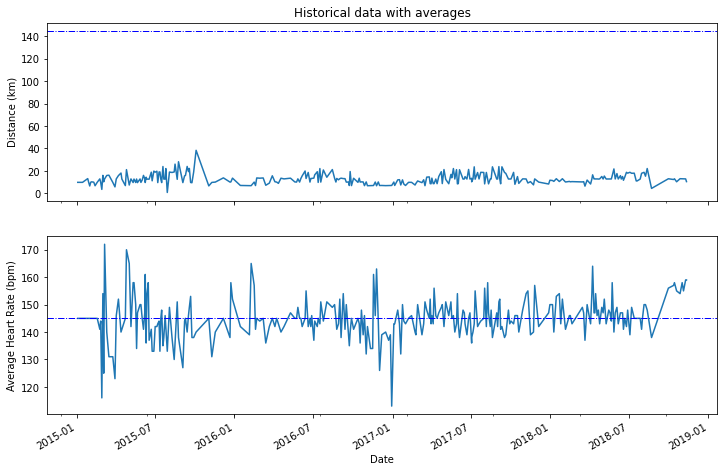

In [263]:
# Prepare data
runs_distance=runs_subset_2015_2018['Distance (km)']
runs_hr=runs_subset_2015_2018['Average Heart Rate (bpm)']

# Create plot
fig, (ax1, ax2)=plt.subplots(2, sharex=True,sharey=False, figsize=(12,8))

# Plot and customize first subplot
runs_distance.plot(ax=ax1)
ax1.set_ylabel('Distance (km)')
ax1.set_title('Historical data with averages')
ax1.axhline(y=runs_hr.mean(),color='b',linewidth=1, linestyle='-.')
# Plot and customize second subplot
runs_hr.plot()
ax2.set_ylabel('Average Heart Rate (bpm)')
ax2.set_xlabel('Date')
ax2.axhline(y=runs_hr.mean(),color='b',linewidth=1, linestyle='-.')
# Show plot
plt.show()

To motivate myself to run regularly, I set a target goal of running 1000 km per year. Let's visualize my annual running distance (km) from 2013 through 2018 to see if I reached my goal each year. Only stars in the green region indicate success.

### Part 7.
- Subset `df_run` for data from 2013 through 2018 and select the `Distance (km)` column. Count annual totals with `resample()` and `sum()`. Assign the result to `df_run_dist_annual`
- Create a plot with `plt.figure()`, setting `figsize` to define a plot of size 8.0 inches x 5.0 inches
- Plot `df_run_dist_annual` and call the plot `ax`. Inside the call to plot, set `marker='*'`, `markersize=14`, `linewidth=0`, `color='blue'` to create large blue stars for each annual total mileage
- Customize the plot with horizontal span from 0 to 800 km with `ax.axhspan()`. Set `color` to `'red'` and `alpha` to `0.2`. Repeat this for the span from 800 to 1000 km and set `color` to `'yellow'` and `alpha` to `0.3`. Repeat this again for the span from 1000 to 1210 and set `color` to `'green'` and `alpha` to `0.4`
- Show the plot with `plt.show()`

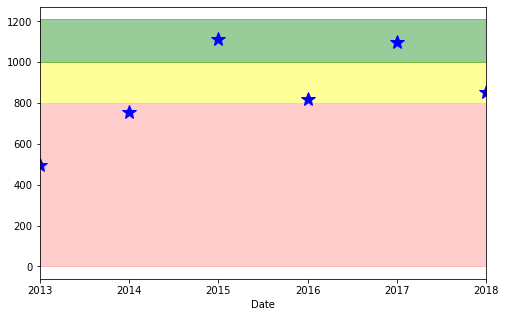

In [264]:
# Prepare data
runs_subset_2013_2018=df_run['2018-12-31':'2013-1-1']
df_run_dist_annual=runs_subset_2013_2018['Distance (km)'].resample('1y').sum()
df_run_dist_annual

# Create plot
plt.figure(figsize=(8,5))



# Plot and customize
ax=df_run_dist_annual.plot(marker='*',markersize=14, linewidth=0, color='blue')
ax.axhspan(0,800,color='red',alpha=0.2)
ax.axhspan(800,1000, alpha=0.4, color='yellow')
ax.axhspan(1000,1210, alpha=0.4, color='green')
# Show plot
plt.show()

Heart rate is a popular metric used to measure training intensity. Depending on age and fitness level, heart rates are grouped into different zones that people can target depending on training goals. A target heart rate during moderate-intensity activities is about 50-70% of maximum heart rate, while during vigorous physical activity it’s about 70-85% of maximum.

We'll create a distribution plot of my heart rate data by training intensity. It will be a visual presentation for the number of activities from predefined training zones.

### Part 8.
- Subset `df_run` from March 2015 through 2018 then select the `'Average Heart Rate (bpm)'` column. Assign the result to `df_run_hr_all`
- Create a plot with `plt.subplots()`, setting `figsize` to `(8,5)`. Assign the result to `fig, ax`
- Create customized x-axis ticks with `ax.xaxis.set()` and passing the `hr_zones` to the `ticks` parameter. Use  `ax.set_xticklabels()` and set the parameters `labels` to `zone_names`, `rotation` to `-30`, and `ha` to `'left'`. Use `ax.set()` to set the `title` as `'Distribution of HR'` and the `ylabel` as `'Number of runs'`
- Show the plot with `plt.show()`

In [ ]:
# Prepare data
hr_zones = [100, 125, 133, 142, 151, 173]
zone_names = ['Easy', 'Moderate', 'Hard', 'Very hard', 'Maximal']
zone_colors = ['green', 'yellow', 'orange', 'tomato', 'red']


# Create plot


# Plot and customize
n, bins, patches = ax.hist(df_run_hr_all, bins=hr_zones, alpha=0.5)
for i in range(0, len(patches)):
    patches[i].set_facecolor(zone_colors[i])



# Show plot


With all this data cleaning, analysis, and visualization, let's create detailed summary tables of my training.

To do this, we'll create two tables. The first table will be a summary of the distance (km) and climb (m) variables for each training activity. The second table will list the summary statistics for the average speed (km/hr), climb (m), and distance (km) variables for each training activity.

### Part 9.
- Concatenate the `df_run` DataFrame with `df_walk` and `df_cycle` using `append()`, then `sort` based on the index in descending order. Assign the result to `df_run_walk_cycle`
- Group `df_run_walk_cycle` by activity type, then select the columns in `dist_climb_cols`. Sum the result using `sum()`. Assign the result to `df_totals` and print the result.
- Use the `stack()` method on `df_summary` to show a compact reshaped form of the full summary report.

In [257]:
dist_climb_cols, speed_col = ['Distance (km)', 'Climb (m)'], ['Average Speed (km/h)']

# Concatenate three DataFrames using append
df_run_walk_cycle = df_run.append([df_walk, df_cycle], sort = True, ignore_index = True)


# Calculate total distance and climb in each type of activities
df_totals = df_run_walk_cycle[dist_climb_cols].groupby(df_run_walk_cycle['Type']).sum()
print(df_totals)
print()


# Calculating summary statistics for each type of activities 

dist_climb_speed_col = ['Distance (km)', 'Climb (m)', 'Average Speed (km/h)']
df_summary = df_run_walk_cycle[dist_climb_speed_col].groupby(df_run_walk_cycle['Type']).describe()


# Combine totals with summary
for i in dist_climb_cols:
    df_summary[i,'total'] = df_totals[i]
    
    
# Stack and print summary statistics
print('----------------------------------------')
print(df_summary.stack())


         Distance (km)  Climb (m)
Type                             
Cycling         680.58       6976
Running        5224.50      57278
Walking          33.45        349

----------------------------------------
               Average Speed (km/h)     Climb (m)  Distance (km)
Type                                                            
Cycling 25%               16.980000    139.000000      15.530000
        50%               19.500000    199.000000      20.300000
        75%               21.490000    318.000000      29.400000
        count             29.000000     29.000000      29.000000
        max               24.330000    553.000000      49.180000
        mean              19.125172    240.551724      23.468276
        min               11.380000     58.000000      11.410000
        std                3.257100    128.960289       9.451040
        total                   NaN   6976.000000     680.580000
Running 25%               10.495000     54.000000       7.415000
        